In [3]:
'''This notebook is a contribution to the study of AI assisted image detection and demarcation for cancer. 
Due to highly fatal nature of Gliomblastoma Tumors, which is used for segmentation is this notebook it is useful
to obtain the cancerous region for clinical relevance, ie, to detect patient survival rate and also in surgical 
intervention.

The code is entirely in Python language and the steps are marked with comments '''

# IMPORT LIBRARIES : OPENCV-PYTHON, NUMPY, MATPLOTLIB.PYPLOT
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [1]:
# IMPORT LIBRARIES : TORCH, TORCHVISION, SYS, SEGMENT_ANYTHING 
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False


In [ ]:
# IMPORT LIBRARIES: SUPERVISION FOR VISUALISTION OF MASKED/ANNOTATED IMAGES

import supervision as sv

In [4]:
#MAIN_PATH_VAL IS THE DIRECTORY FOR THE SELECTED IMAGE 
main_path_val  ='/Users/anantgokhale/Desktop/Screenshot 2023-06-25 at 2.17.03 AM.png'
#NEW_FOLDER_NAE IS THE DIRECTORY FOR SAVING THE FINAL CONTOUR DEMARCATED IMAGE FILE 
new_folder_name ='/Users/anantgokhale/glioma-segment/src'

#COORDINATES OF BOUNDING BOX 
#RUN DRAW4.PY TO GET VALUES
(420,386)
(670,646)

#TOP ROW INDEX
in1 = 420
#BOTTOM ROW INDEX
in2 = 670
#RIGHT COLOUMN INDEX
in3 = 386
#LEFT COLOUMN INDEX
in4 = 646

In [144]:
# FUNCTION DEFINATIONS FOR LATER USE

# FINDS CENTROID OF NON-BLACK REGION OR THE REGION WHERE INTENSITY IS NOT ZERO
def find_centroid(image):
        indices = np.where(image != 0)
        centroid_y = np.sum(indices[0]) // len(indices[0])
        centroid_x = np.sum(indices[1]) //len(indices[1])
        centroid = (centroid_y, centroid_x)
        return centroid

# DRAW ANNOTATIONS ON SAM_RESULT. 
# THIS FUNCTION IS NOT USED IN THIS NOTEBOOK
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            final_ = np.dstack((img, m*0.35))
        ax.imshow(final_)


PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False


(251, 261, 3)


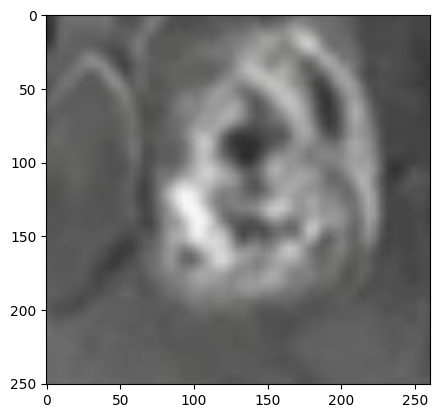

In [10]:
# READ IMAGE
image = cv2.imread(main_path_val)
# SELECT BOUNDINX-BOX REGION
image_roi = image[in1:in2+1, in3:in4+1,:]
# SHOW IMAGE WITH MATPLOTLIB INLINE
# THE IMAGE HAS THREE CHANNELS.
print(image_roi.shape)
plt.imshow(image_roi)

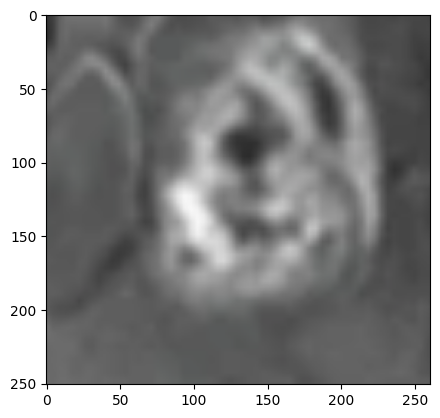

In [11]:
# ALTHOUGH THE IMAGE IS THREE CHANNEL IT IS NOT AN RGB IMAGE
this_new_image = cv2.cvtColor(image_roi, cv2.COLOR_BGR2RGB)
plt.imshow(this_new_image)

In [159]:
''' During the testing with SAM Model it was seem that it was recognising differences of the tumor,
but the boundary was not clealy distinguishable by the model. Besides there was overlap of masks in
unwanted regions with those of the tumor region. Before sending the image to sam the background is
flattened  '''

#MAKE COPY OF ROI
mean_ij = image_roi.copy()
#TUPLE UNPACKING TO GET SHAPE
m,n,o = mean_ij.shape
#ITERATE OVER ROWS AND COLUMNS OF MEAN_IJ
for i in range(m):
    for j in range(n):
        '''Increase the pixel intenstiy
          below 30,90,120,150,180... to
          a larger value'''
        if np.mean(mean_ij[i][j])<120:
            mean_ij[i][j] = 190

In [165]:
''' Weighted sum of orignal image (image_roi) with mean_ij allows to account for details in orignal
image. The weight of image_roi is high (upto 0.95) to account for details'''

#WEIGHTED SUM 
image_roi =cv2.addWeighted(image_roi, 0.7, mean_ij, 0.3, 0)

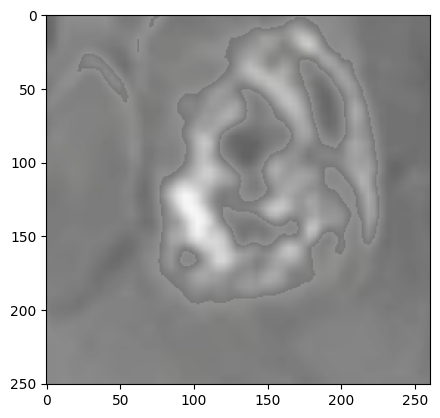

In [166]:
#SHOW IMAGE
plt.imshow(image_roi)

In [633]:
'''Some other methods that were earlier tried...'''

# image = cv2.imread(main_path_val)
# image_roi = image[in1:in2+1, in3:in4+1,:]
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# # plt.imshow(image_roi)
# # window_name = ('Sobel Demo - Simple Edge Detector')
# scale = 1
# delta = 0
# ddepth = cv2.CV_16S
# # print(image_roi.shape)    
# # image = cv2.imread(main_path_val)
# image = image_roi
# src = cv2.GaussianBlur(image, (3, 3), 0)
    
    
# gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)


# grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# # Gradient-Y
# # grad_y = cv2.Scharr(gray,ddepth,0,1)
# grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)


# abs_grad_x = cv2.convertScaleAbs(grad_x)
# abs_grad_y = cv2.convertScaleAbs(grad_y)


# grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
# # width =int(grad.shape[0]*0.25)
# # height = int(grad.shape[1]*0.25)
# # grad = cv2.resize(src = grad, dsize = (width, height), interpolation = cv2.INTER_CUBIC)
# m,n = grad.shape
# for i in range(m):
#     for j in range(n):
#         if grad[i][j]<30:
#             grad[i][j] = 255
# grad = grad*4

# # grad = cv2.cvtColor(grad, cv2.COLOR_GRAY2RGB)
# # plt.imshow(grad, cmap ='gray')

# # image_roi = cv2.addWeighted(grad, 0.9, gray, 0.1, 0)
# # image_roi = grad
# # layer1 = np.ones_like(grad)*30
# # layer2 = np.ones_like(grad)*30
# # grad = np.atleast_3d(grad)
# # stacked_arr = np.repeat(grad[:, :, np.newaxis], 3, axis=2)

# # np.stack((grad,grad,grad),axis=-1)
# # grad[:,:,0] = grad
# # grad[:,:,1] = layer1
# # grad[:,:,2] = layer2 
# grad = np.expand_dims(grad, axis=2)
# grad = np.repeat(grad, 3, axis=2)

# plt.imshow(grad)
# print(grad.shape)
# cv2.imwrite('/Users/anantgokhale/Downloads/248.png', grad)

In [634]:
'''Some other methods that were earlier tried...'''

# pic_blur = cv2.medianBlur(grad,3)
# plt.imshow(pic_blur)

In [635]:
'''Some other methods that were earlier tried...'''

# zeros = np.zeros((200,200,3), dtype = np.uint8)
# zeros[:44, :65,:] = grad
# grad.shape

In [ ]:
'''Some other methods that were earlier tried...'''

# gray=cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
# mean_val = gray.mean()
# # for arr1d in gray:
# #     for value in arr1d:
# #         if value < 30:
# #             value = mean_val
# plt.imshow(gray, cmap = 'gray')   

In [ ]:
'''Some other methods that were earlier tried...'''

# plt.imshow(image_roi)
# lol = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
# lol = cv2.adaptiveThreshold(lol,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(lol)

In [167]:
#PRINT AND CHECK PARAMETERS
print('Shape of Image_roi')
print(image_roi.shape)

#FIND CENTROID
centre_roi = find_centroid(image_roi)
# LINEAR TRANSFORMATION TO OBTAIN CENTRE ON IMAGE FROM WHICH BOUNDING-BOX REGION WAS OBTAINED
centre =(in1 + centre_roi[0], in3 + centre_roi[1])

#PRINT AND CHECK PARAMETERS
print('Centroid of roi in orignal image')
print(centre)
image_roi = image_roi


Shape of Image_roi
(251, 261, 3)
Centroid of roi in orignal image
(545, 516)


In [168]:
#INITIALISE SAM MODEL
sam_checkpoint = "/Users/anantgokhale/Downloads/sam_vit_h_4b8939.pth"
model_type = "vit_h"

#SELECT DEVICE. MPS IS AVAILABLE IN PYTORCH ONLY FOR MACOS VENTURA USERS.
# OTHER DEVICE -> 'cuda'
device = 'cpu'
if device =='mps':
    print('True')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#MASK GENERATOR OBJECT INITIALISATION. 
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

#GENERATE MASKS
masks1 = mask_generator_.generate(image_roi)
print('MASKS1 SUCCESSFULLY GENERATED')
print(len(masks1))

MASKS1 SUCCESSFULLY GENERATED
17


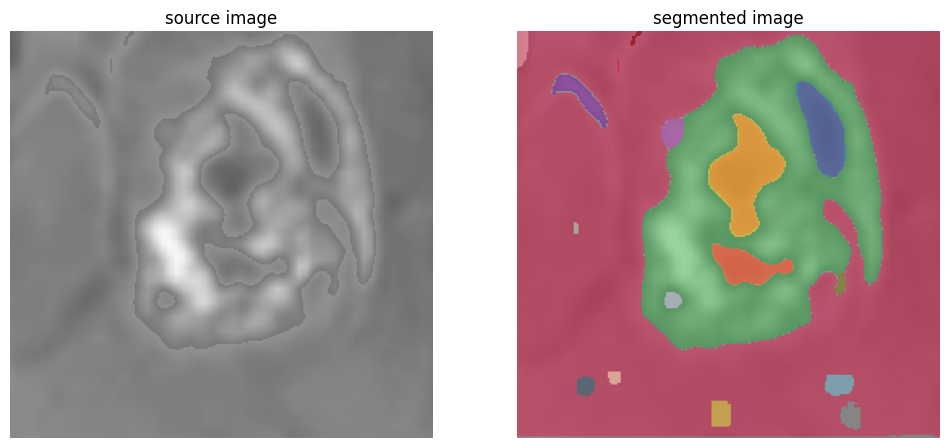

In [169]:
#VISUALISE IMAGES


#GET MASK MASKANNOTATOR
mask_annotator = sv.MaskAnnotator()

#GET DETECTIONS FROM SAM_RESULT
detections1 = sv.Detections.from_sam(sam_result=masks1)

#GET ANNOTATED IMAGE FROM DETECTIONS AND IMAGE_ROI
annotated_image1 = mask_annotator.annotate(scene=image_roi.copy(), detections=detections1)

#PLOT IMAGES IN A GRID
sv.plot_images_grid(
    #PUT SELECTED IMAGES IN A LIST
    images=[image_roi, annotated_image1],
    #NUMBER OF IMAGES 1ROW*2COLUMN 
    grid_size=(1, 2),
    # IMAGE TITLES
    titles=['source image', 'segmented image'])

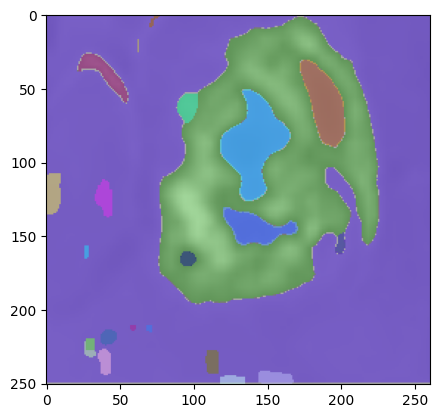

In [102]:
#PLOT ONLY ANNOTATED IMAGE WITH MATHPLOTLIB.PYPLOT

plt.imshow(annotated_image1)

In [114]:
'''Using the boundinx box ensures that the larger annotated mask is the tumor. It is either of the first three 
larger masks. A different method is tried here as only one mask is selected (see for loop) '''

# SORTED ANNOTATION OF MASKS
sorted_anns = sorted(masks1, key=(lambda x: x['area']), reverse=True)
# AREA IMAGE_ROI
area = (in2-in1) * (in4-in3)
#PRINT PARAMETER
print(area)
# CREATE A BLANK SCREEN. 
zero_mat = np.zeros_like(image_roi, dtype=np.uint8)

#CHOOSE MASK ON BASIS OF AREA
for ann in sorted_anns:
    cnt_area = ann['area']
    '''Area of tumor masks vary. Here the smallest
    mask (in area) above the lower limit is selected.
    Number of Contour found printed tells index of mask'''
    
    if 0.2*area < cnt_area < area:
        
        zero_mat= np.zeros_like(image_roi, dtype=np.uint8)
        print('Contour Found!')
        # ANN REPRESENTS PROPERTIES OF EACH MASK WHICH CAN OBTAINED FROM DICTIONARY KEYS LIKE -> 'area', 'segmentation', etc
        print(ann['area'])
        # GET THE VALUE FOR THE DICTIONARY KEY 'segmentation'. IT IS A BOOLEAN MATRIX OF THE ONE OF MANY MASKS
        bool_mat = ann['segmentation']
        # GET MASK ON BLANK SCREEN (ZERO_MAT) USING BOOLEAN INDEXING. SET TRUE VALUES TO 255
        zero_mat[bool_mat] = 255

65000
Contour Found!
47147
Contour Found!
16802


In [644]:
'''Some other methods that were earlier tried...'''

# list_sq = [1,4,9,16,25,36,49]

# val = sum(list_sq < len(masks1))
# print(list_sq[val-1])

# for ann in sorted_anns:
#     plt.add(ann['segmentation'])

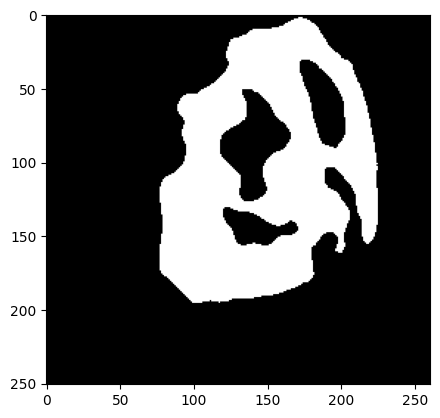

In [115]:

# THRESHOLD IMAGE
ret, zero_mat = cv2.threshold(zero_mat, 0, 255, cv2.THRESH_BINARY)
# PLOT ZERO_MAT WITH MATPLOTLIB.PYPLOT
plt.imshow(zero_mat)

In [116]:
# CALCULATE IMAGE CENTRE OF ZERO_MAT. THIS WAS USED FOR CHECKING WITH IMAGE_ROI IMAGE CENTRE (CENTROID).
centre_roi2 = find_centroid(zero_mat)
# LINEAR TRANSFORMATION TO GET CENTRE ON ORIGNAL IMAGE ON WHICH THE BOUNDING BOX WAS DRAWN
centre2 =(in1 + centre_roi2[0], in3 + centre_roi2[1])
# PRINT TRANSFORMED CENTRE. THIS MAY BE VISUALISED BY DRAWING A CIRCLE WITH CV2.CIRCLE METHOD ON ORIGNAL IMAGE
print(centre2)

(526, 533)


In [117]:
# COMPARE CENTRES OF IMAGE_ROI AND ZERO_MAT. THIS WAS USED FOR CHECKING 
print(centre, centre2)

(545, 516) (526, 533)


In [118]:
# AGAIN GET ORIGNAL IMAGE AS IN THE BEGINNING OF NOTEBOOK IN NEW VARIABLE IMAGE_BIG
imagebig = cv2.imread(main_path_val)

In [119]:
# CREATE A NEW VARIABLE IMAGE ASSIGNED TO A ZERO_MAT
image = zero_mat



In [120]:
'''r1 is for image with no resize. r2 is image resised to 1.7 times image variable area. r3 is image 
resised to 1.3 times image variable area '''

r1shape0, r1shape1, r1shape2 = image.shape
width_r1 = int(np.sqrt(1.70)  *  r1shape1)
height_r1 = int(np.sqrt(1.70) *  r1shape0)
# IMAGE RESIZE
r1image = cv2.resize(src = image, dsize = (width_r1, height_r1), interpolation = cv2.INTER_CUBIC)
# IMAGE BLUR TO REMOVE UNNECESARY PIXELATED REGIONS. SUCH THAT NO UNNECESARY EDGES ARE DETECTED AS CONTOURS.
r1image_blur = cv2.GaussianBlur(r1image, (3,3), 0)

In [121]:
r2shape0, r2shape1, r2shape2 = image.shape
width_r2 = int(np.sqrt(1.30)  *  r2shape1)
height_r2 = int(np.sqrt(1.30) *  r2shape0)
# IMAGE RESIZE
r2image = cv2.resize(src = image, dsize = (width_r2, height_r2), interpolation = cv2.INTER_CUBIC)
# IMAGE BLUR TO REMOVE UNNECESARY PIXELATED REGIONS. SUCH THAT NO UNNECESARY EDGES ARE DETECTED AS CONTOURS.
r2image_blur = cv2.GaussianBlur(r2image, (3,3), 0)

4


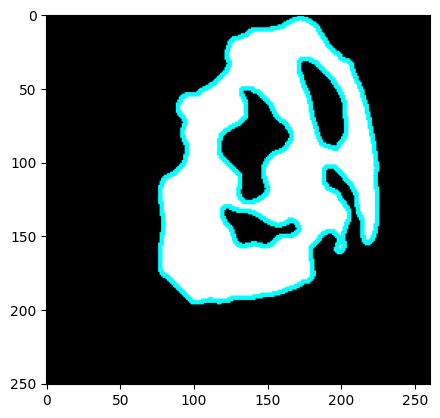

In [122]:
# IMAGE VARIABLE IS CONVERTED TO GRAY BEFORE DRAWING CONTOURS AS ONLY SINGLE DIMENSION ARRAY IS ACCEPTED BY CV2.FINDCONTOURS()
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#! ! ! NO BLURRING IN ORIGNAL
# <---blur line----> (LINE LEFT FOR BLURRING ORIGNAL IMAGE. (FOR CHECKING DIFFERENCES IN RESULT ONLY.)

#FIND CONOTOURS. HIERARCHY IS NOT USED. IT WAS USED DURING CHECKING. HIERARCHY ALLOWED SELECTION OF OUTERMOST CONTOURS SELECTED DURING CHECKING PROCESS.
contours, hierarchy = cv2.findContours(image_gray.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# PRINT NUMBER OF CONTOURS
print(len(contours))
# DELETE VARIABLE
del image_gray

# CREATE IMAGE VARIABLE COPY TO DRAWCONTOURS ON
image_copy = image.copy()
for i in range(len(contours)):
    cv2.drawContours(image_copy,contours, i, (0,255,255), 2)
plt.imshow(image_copy)

In [123]:
# CALCULATE CENTROID WIT CV2.MOMENTS METHOD
moments = cv2.moments(contours[0])
centroidx = int(moments["m10"] / moments["m00"])
centroidy = int(moments["m01"] / moments["m00"])
del moments 

In [124]:
print(centre_roi2, (centroidy, centroidx))

(106, 147) (103, 148)


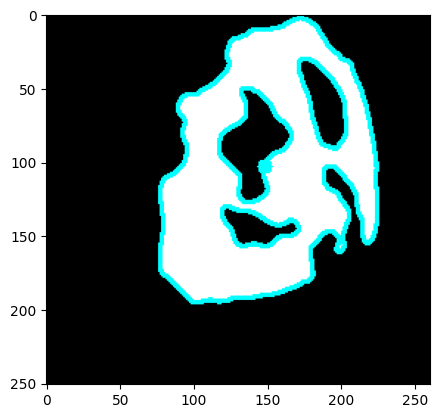

In [125]:
# DRAW CENTROID ON IMAGE_COPY_COPY FOR CHECKING ONLY
image_copy_2 = image_copy.copy()
cv2.circle(image_copy,(centroidx, centroidy) , 5,(0,255,255), -1)
plt.imshow(image_copy)

In [126]:
# IMAGE VARIABLE IS CONVERTED TO GRAY BEFORE DRAWING CONTOURS AS ONLY SINGLE DIMENSION ARRAY IS ACCEPTED BY CV2.FINDCONTOURS()
r1image_gray = cv2.cvtColor(r1image_blur, cv2.COLOR_BGR2GRAY)

#FIND CONOTOURS. HIERARCHY IS NOT USED. IT WAS USED DURING CHECKING. HIERARCHY ALLOWED SELECTION OF OUTERMOST CONTOURS SELECTED DURING CHECKING PROCESS.
contours2, hierarchy = cv2.findContours(r1image_gray.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# PRINT NUMBER OF CONTOURS
print(len(contours2))

# DELETE VARIABLE
del r1image_gray

# CREATE IMAGE VARIABLE COPY TO DRAWCONTOURS ON
r1image_copy =r1image.copy()
for i in range(len(contours2)):
    cv2.drawContours(r1image_copy,contours2, i, (0,255,255), 2)
# CALCULATE CENTROID WIT CV2.MOMENTS METHOD
moments = cv2.moments(contours2[0])
centroidx_r1 = int(moments["m10"] / moments["m00"])
centroidy_r1 = int(moments["m01"] / moments["m00"])
del moments    

4


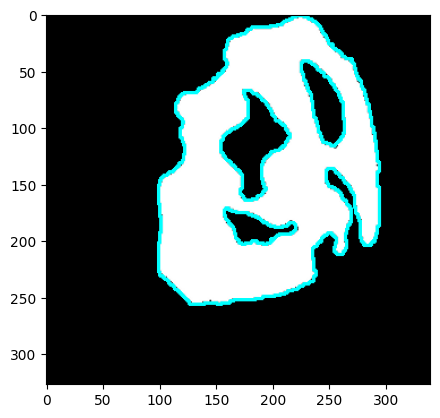

In [127]:
plt.imshow(r1image_copy)

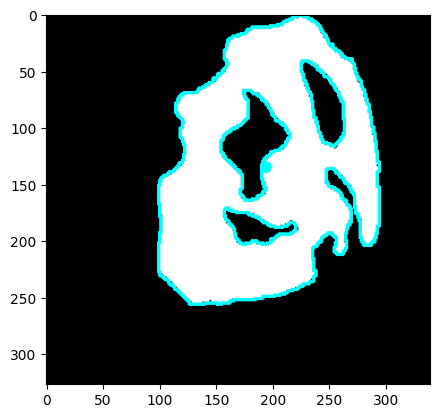

In [128]:
# DRAW CENTROID ON IMAGE_COPY_COPY FOR CHECKING ONLY
r1image_copy_copy = r1image_copy.copy()
r1image_copy_copy = cv2.circle(r1image_copy_copy, (centroidx_r1, centroidy_r1), 5,(0,255,255), -1)
plt.imshow(r1image_copy_copy)

In [129]:
# IMAGE VARIABLE IS CONVERTED TO GRAY BEFORE DRAWING CONTOURS AS ONLY SINGLE DIMENSION ARRAY IS ACCEPTED BY CV2.FINDCONTOURS()
r2image_gray = cv2.cvtColor(r2image_blur, cv2.COLOR_BGR2GRAY)

#FIND CONOTOURS. HIERARCHY IS NOT USED. IT WAS USED DURING CHECKING. HIERARCHY ALLOWED SELECTION OF OUTERMOST CONTOURS SELECTED DURING CHECKING PROCESS.
contours3, hierarchy = cv2.findContours(r2image_gray.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# PRINT NUMBER OF CONTOURS
print(len(contours3))

# DELETE VARIABLE
del r2image_gray

# CREATE IMAGE VARIABLE COPY TO DRAWCONTOURS ON
r2image_copy =r2image.copy()
for i in range(len(contours3)):
    cv2.drawContours(r2image_copy,contours3, i, (0,255,255), 2)
# CALCULATE CENTROID WIT CV2.MOMENTS METHOD
moments = cv2.moments(contours3[0])
centroidx_r2 = int(moments["m10"] / moments["m00"])
centroidy_r2 = int(moments["m01"] / moments["m00"])
del moments    

4


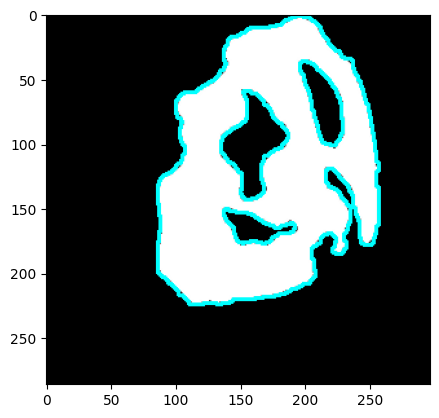

In [130]:
plt.imshow(r2image_copy)

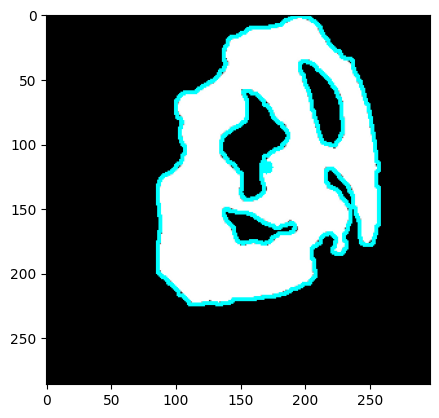

In [131]:
# DRAW CENTROID ON IMAGE_COPY_COPY FOR CHECKING ONLY
r2image_copy_copy = r2image_copy.copy()
r2image_copy_copy = cv2.circle(r2image_copy_copy, (centroidx_r2, centroidy_r2), 5,(0,255,255), -1)
plt.imshow(r2image_copy_copy)

In [132]:
#CENTROID OF NON RESISED OR ZERO_MAT WITH LINEAR TRANSFORMATION ON IMAGEBIG IMAGE 
centre2 = (centroidy+in1, centroidx+in3)

In [133]:
# # DISTANCE BY WHICH CONTOUR WILL BE MOVED DURING LINEAR TRANSFORMATION TO REACH CENTRE OF TUMOR ON ORIGNAL IMAGE. HERE IT IS IN1 AND IN3
centre2
distancey = centre2[0] - centroidy
distancex = centre2[1] - centroidx


In [134]:
# DISTANCE BY WHICH CONTOUR WILL BE MOVED DURING LINEAR TRANSFORMATION TO REACH CENTRE OF TUMOR ON ORIGNAL IMAGE
centre2
distancey_r1 = centre2[0] - centroidy_r1
distancex_r1 = centre2[1] - centroidx_r1


In [135]:
# DISTANCE BY WHICH CONTOUR WILL BE MOVED DURING LINEAR TRANSFORMATION TO REACH CENTRE OF TUMOR ON ORIGNAL IMAGE
centre2
distancey_r2 = centre2[0] - centroidy_r2
distancex_r2 = centre2[1] - centroidx_r2

In [136]:
#COPY OF FIRST CONTOUR IN ARRAY FORM. FIRST CONTOUR IS THE LARGEST CONTOUR WHICH WILL ENCLOSE THE ENTIRE TUMOR
contourscopy = np.array(contours[0])
# PERFORM LINEAR TRANSFORMATION FROM THE DISTANCES CALCULATED EARLIER
for arr1d in contourscopy:
    arr1d[0,0]+= distancex
    arr1d[0,1]+= distancey
'''Contours object is an array in a tuple form. Where each array has coordintaes. For cv2.drawcontours
 to recognise object as contour enclosing it in a tuple'''
# ENCLOSE CONTOURSCOPY IN A TUPLE
contourscopy_tuple = (contourscopy,) 


In [137]:
#COPY OF FIRST CONTOUR2 IN ARRAY FORM. FIRST CONTOUR2 IS THE LARGEST CONTOUR WHICH WILL ENCLOSE THE ENTIRE TUMOR
contours2copy = np.array(contours2[0])
# PERFORM LINEAR TRANSFORMATION FROM THE DISTANCES CALCULATED EARLIER
for arr1d in contours2copy:
    arr1d[0,0]+= distancex_r1
    arr1d[0,1]+= distancey_r1
'''Contours object is an array in a tuple form. Where each array has coordintaes. For cv2.drawcontours
 to recognise object as contour enclosing it in a tuple'''
# ENCLOSE CONTOURSCOPY IN A TUPLE
contours2copy_tuple = (contours2copy,)

In [138]:
#COPY OF FIRST CONTOUR3 IN ARRAY FORM. FIRST CONTOUR3 IS THE LARGEST CONTOUR WHICH WILL ENCLOSE THE ENTIRE TUMOR
contours3copy = np.array(contours3[0])
# PERFORM LINEAR TRANSFORMATION FROM THE DISTANCES CALCULATED EARLIER
for arr1d in contours3copy:
    arr1d[0,0]+= distancex_r2
    arr1d[0,1]+= distancey_r2
'''Contours object is an array in a tuple form. Where each array has coordintaes. For cv2.drawcontours
 to recognise object as contour enclosing it in a tuple'''
# ENCLOSE CONTOURSCOPY IN A TUPLE
contours3copy_tuple = (contours3copy,)
 

In [139]:
# COPY OF IMAGEBIG VARIABLE TO DRAW CONTOURS, CONTOURS2, CONTOURS3
draw_image = imagebig.copy()
#DRAW INNER CONTOUR
for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)
#DRAW SECOND CONTOUR    
for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i,(0,255,255) , 2)
#DRAW OUTER CONTOUR
for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i, (255,255,0), 2)

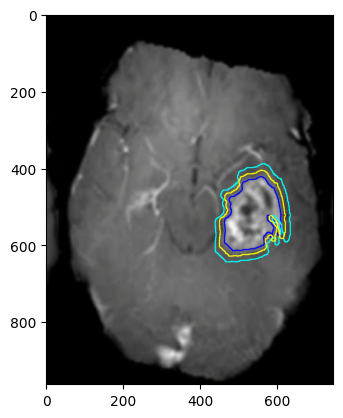

In [140]:
#SHOW IMAGE USING MATPLOTLIB.PYPLOT
plt.imshow(draw_image)

In [141]:
#SAVE IMAGE IN NEW_FOLDER_NAME WITH A FILENAME
cv2.imwrite(new_folder_name+'/bad-case2-ann.png', draw_image)

True

#### Some Other Tests

In [12]:

image0014_bgr = cv2.imread('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/testfig0013.png')
image0014_rgb = cv2.cvtColor(image0014_bgr, cv2.COLOR_BGR2RGB)
image0015_bgr = cv2.imread('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/testfig0014.png')
image0015_rgb = cv2.cvtColor(image0015_bgr, cv2.COLOR_BGR2RGB)
image0016_bgr = cv2.imread('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/testfig0015.png')
image0016_rgb = cv2.cvtColor(image0016_bgr, cv2.COLOR_BGR2RGB)
image0017_bgr = cv2.imread('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/testfig0016.png')
image0017_rgb = cv2.cvtColor(image0017_bgr, cv2.COLOR_BGR2RGB)



In [13]:
draw_image = image0014_bgr.copy()

for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)

for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i, (0,255,255), 2)

for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i, (255,255,0), 2)  

plt.imshow(draw_image)

NameError: name 'contourscopy_tuple' is not defined

In [ ]:
cv2.imwrite(new_folder_name+'/rings-attempt2-0013.png', draw_image)

True

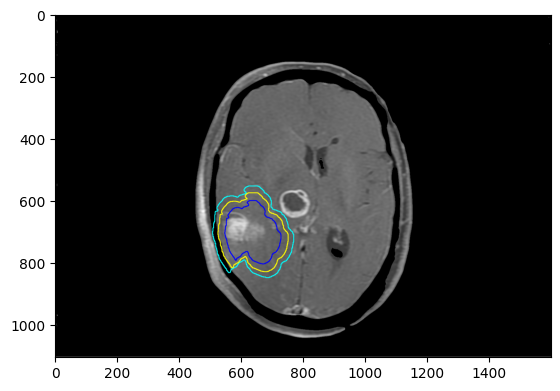

In [ ]:
draw_image = image0015_bgr.copy()

for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)

for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i,(0,255,255) , 2)

for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i,(255,255,0) , 2)  

plt.imshow(draw_image)

In [ ]:
cv2.imwrite(new_folder_name+'/rings-attempt2-0014.png', draw_image)

True

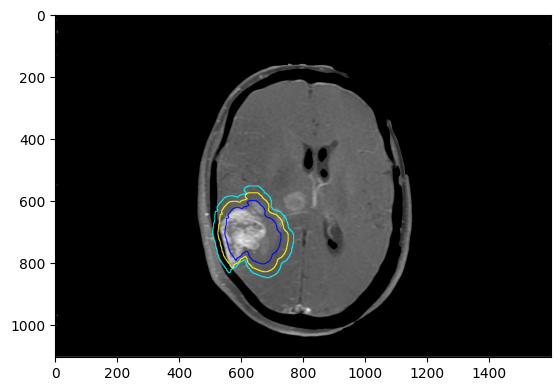

In [ ]:
draw_image = image0016_bgr.copy()

for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)

for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i,(0,255,255) , 2)

for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i, (255,255,0), 2)  

plt.imshow(draw_image)

In [ ]:
cv2.imwrite(new_folder_name+'/rings-attempt2-0015.png', draw_image)

True

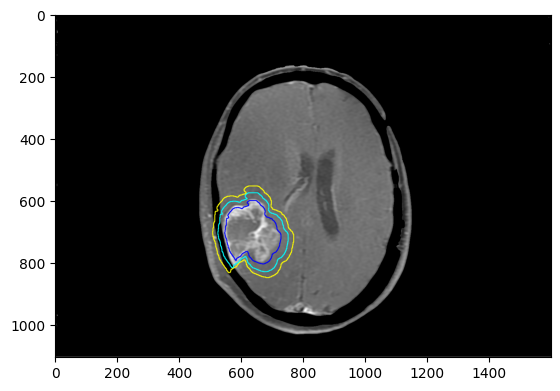

In [ ]:
draw_image = image0017_bgr.copy()

for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)

for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i,(255,255,0) , 2)

for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i, (0,255,255), 2)  

plt.imshow(draw_image)

In [ ]:
# cv2.imwrite(new_folder_name+'/rings0016.png', draw_image)

In [ ]:
%store contours
%store contours2
%store contours3

Stored 'contours' (tuple)
Stored 'contours2' (tuple)
Stored 'contours3' (tuple)


In [ ]:
value_list = [(842, 671),(697, 559)]
value_list[0][0]

842

In [ ]:
in1,in2 = (value_list[0][1],value_list[1][1]) if value_list[0][1] < value_list[1][1] else (value_list[1][1],value_list[0][1])

In [ ]:
in3,in4 = (value_list[0][0],value_list[1][0]) if value_list[0][0] < value_list[1][0] else (value_list[1][0],value_list[0][0])

In [ ]:
print(in1, in2)
print(in3, in4)

559 671
697 842


In [ ]:
path_val = '/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/testfig0013.png'
some_val = path_val[-8:-4]
print(some_val)

0013


In [ ]:
maxd_a = np.array(contourscopy_tuple[0])



In [ ]:
some_bgr = cv2.imread('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/rings-from-testfig0013/rings0015.png')

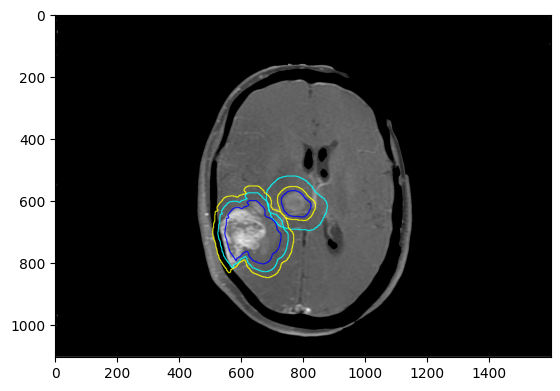

In [ ]:
draw_image = some_bgr.copy()

for i in range(len(contourscopy_tuple)):
    cv2.drawContours(draw_image, contourscopy_tuple, i, (0,0,255), 2)

for i in range(len(contours2copy_tuple)):
    cv2.drawContours(draw_image, contours2copy_tuple, i,(255,255,0) , 2)

for i in range(len(contours3copy_tuple)):
    cv2.drawContours(draw_image, contours3copy_tuple, i, (0,255,255), 2)  

plt.imshow(draw_image)

In [ ]:
text = "Image is for visualization purposes only"
font = cv2.FONT_HERSHEY_SIMPLEX
scale = 1.0
color = (255, 255,255)
thickness = 1
text_size, _ = cv2.getTextSize(text, font, scale, thickness)
text_position = (10, text_size[1] + 10)

cv2.putText(draw_image,text, text_position, font, scale, color, thickness, cv2.LINE_AA)

array([[[68, 68, 68],
        [68, 68, 68],
        [68, 68, 68],
        ...,
        [68, 68, 68],
        [68, 68, 68],
        [68, 68, 68]],

       [[68, 68, 68],
        [68, 68, 68],
        [68, 68, 68],
        ...,
        [68, 68, 68],
        [68, 68, 68],
        [68, 68, 68]],

       [[68, 68, 68],
        [68, 68, 68],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [68, 68, 68],
        [68, 68, 68]],

       ...,

       [[68, 68, 68],
        [68, 68, 68],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [68, 68, 68],
        [68, 68, 68]],

       [[68, 68, 68],
        [68, 68, 68],
        [68, 68, 68],
        ...,
        [68, 68, 68],
        [68, 68, 68],
        [68, 68, 68]],

       [[68, 68, 68],
        [68, 68, 68],
        [68, 68, 68],
        ...,
        [68, 68, 68],
        [68, 68, 68],
        [68, 68, 68]]], dtype=uint8)

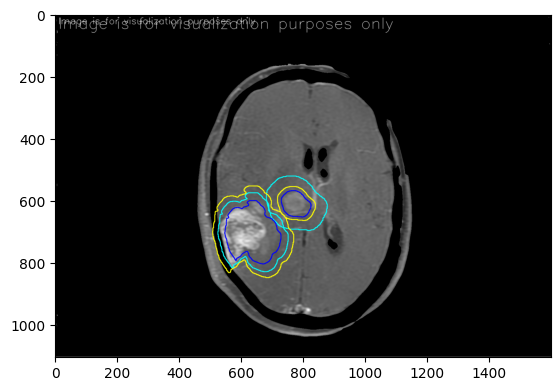

In [ ]:
import cv2
import numpy as np

# Load the image

# Create a white background image with the same dimensions as the original image
background = np.zeros_like(image) + 255  # 255 represents white color

# Define the text to be written
text = "Image is for visualization purposes only"

# Choose the font face, scale, color, and thickness
font = cv2.FONT_HERSHEY_SIMPLEX
scale = 1.7
color = (255, 255, 255)  # Black color in BGR format
thickness = 1

# Get the size of the text
text_size, _ = cv2.getTextSize(text, font, scale, thickness)

# Calculate the position to place the text (top left corner)
text_position = (10, text_size[1] + 10)  # 10 pixels padding from top and left edges

# Write the text on the white background
cv2.putText(draw_image, text, text_position, font, scale, color, thickness, cv2.LINE_AA)

# Add the white background with the text to the original image


# Display the result
plt.imshow(draw_image)


In [ ]:
cv2.imwrite('/Users/anantgokhale/glioma-segment/images-sent-to-sam/case1-attempt2-02-06-23/rings-im.png', draw_image)

True

True

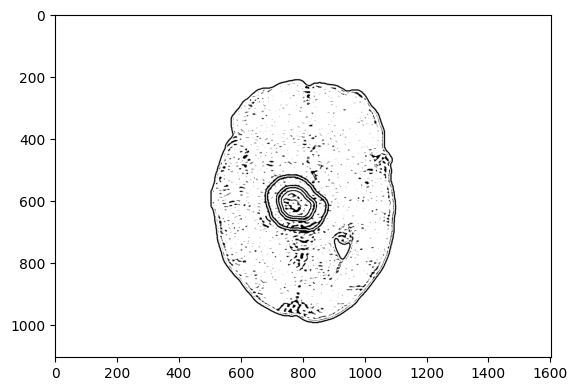

In [14]:
lll = cv2.imread('/Users/anantgokhale/Downloads/Picture 1.png')
lll = cv2.cvtColor(lll, cv2.COLOR_BGR2GRAY)
lll = cv2.adaptiveThreshold(lll,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(lll, cmap='gray')
cv2.imwrite('/Users/anantgokhale/Downloads/image908.png', lll)